In [42]:
!pip install --no-deps tensorflowjs
import tensorflowjs as tfjs

     |████████████████████████████████| 77 kB 4.7 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import string
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.interpolate import make_interp_spline

In [3]:
def countSamplesByClass(df):
  lettersCount = Counter(df)
  plt.figure(figsize=(10,10))
  plt.barh(list(lettersCount.keys()), list(lettersCount.values()))
  plt.title('Quantidade de amostras por letras')
  plt.xlabel('Quantidade de amostras')
  plt.ylabel('Letras')
  plt.show()

In [4]:
def createSpline(x, y):
  X_Y_Spline = make_interp_spline(x, y)
  X_ = np.linspace(min(x), max(x), 500)
  Y_ = X_Y_Spline(X_)
  return (X_, Y_)

In [5]:
def formatFigure(plt):
  plt.grid(False)
  plt.axvline(x=0, c="black", linewidth=1)
  plt.axhline(y=0, xmin=0.05, c="black", linewidth=2)
  ax = plt.gca()
  ax.set_ylim([0, 1.025])
  ax.set_facecolor('white')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

In [75]:
# Só deve descomentar 1 opção
#origemImagens = 'originais'
origemImagens = 'originaisLimpas'
#origemImagens = 'aumentoDeDados'
#origemImagens = 'aumentoDeDadosLimpas'

In [76]:
dicionarioNomesArquivos = {
    'originais': ('dataset.csv', 'labels.csv'),
    'originaisLimpas': ('datasetLimpo.csv', 'labelsLimpo.csv'),
    'aumentoDeDados': ('datasetExpandido.csv', 'labelsExpandido.csv'),
    'aumentoDeDadosLimpas': ('datasetExpandidoLimpo.csv', 'labelsExpandidoLimpo.csv'),
}
(nomeArquivoDataset, nomeArquivoLabels) = dicionarioNomesArquivos[origemImagens]

In [77]:
# Paths para dados
datasetPath = '/content/drive/MyDrive/2021.2/TCC/Testes/Data/DatasetMultiprova/LetrasAJ/' + nomeArquivoDataset
labelsPath = '/content/drive/MyDrive/2021.2/TCC/Testes/Data/DatasetMultiprova/LetrasAJ/' + nomeArquivoLabels
pathToModel = '/content/drive/MyDrive/2021.2/TCC/Modelos/LetrasAJ3Canais/Base'
pathToModelJs = '/content/drive/MyDrive/2021.2/TCC/Modelos/LetrasAJ3Canais/Js'

In [78]:
shapeImg = (32, 32, 3)
quantidadeDeCanais = shapeImg[2]
quantidadeDeClasses = 11

In [79]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '10']
numbersToLetters = {}
lettersToNumbers = {}
for (index, letter) in enumerate(letters):
  lettersToNumbers[letter] = index
  numbersToLetters[index] = letter
print(numbersToLetters)
print(lettersToNumbers)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: '10'}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, '10': 10}


In [80]:
# Carregar dados
dataframe = pd.read_csv(datasetPath).astype('float32')
labels = pd.read_csv(labelsPath, squeeze=True).astype('string')

In [81]:
print('Quantidade de amostras:', len(labels))

Quantidade de amostras: 18444


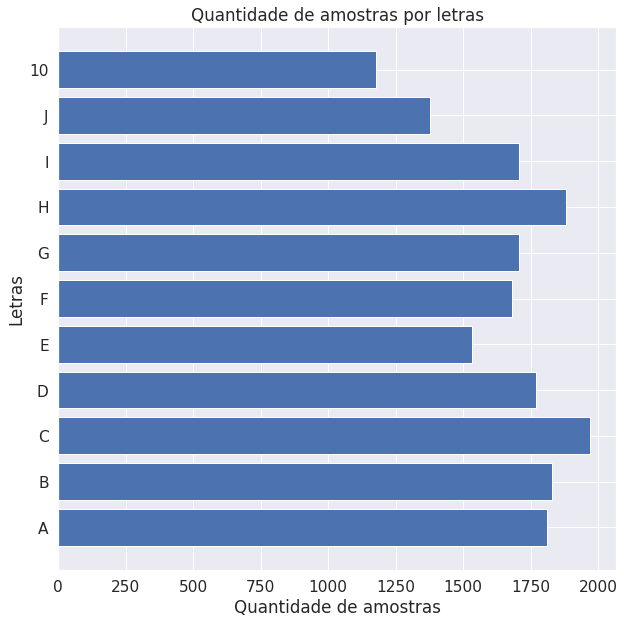

In [82]:
countSamplesByClass(labels)

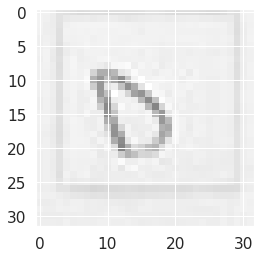

Index: 6339 , Label: D


In [83]:
# Checar se imagem corresponde a label correta
randomIndex = random.randint(0, len(labels))
testImg = dataframe.iloc[randomIndex]
testImg = np.array(testImg).reshape(shapeImg[0], shapeImg[1], quantidadeDeCanais)
plt.imshow(testImg, cmap="gray")
plt.show()
print('Index:', randomIndex, ', Label:', labels.iloc[randomIndex])

In [84]:
dataframeNumpy = dataframe.to_numpy()
dataframeShapeImg = dataframeNumpy.reshape(-1, shapeImg[0], shapeImg[1], quantidadeDeCanais).astype('float32')

In [85]:
labelsInNumbers = labels.map(lettersToNumbers)
labelsFormatedToCNN = to_categorical(labelsInNumbers, quantidadeDeClasses)

In [86]:
dataframeTrain, dataframeTemp, labelsTrain, labelsTemp = train_test_split(dataframeShapeImg, labelsFormatedToCNN, test_size=0.3, random_state=42)
dataframeTest, dataframeVal, labelsTest, labelsVal = train_test_split(dataframeTemp, labelsTemp, test_size=0.5, random_state=42)

In [91]:
# Criar estrutura da CNN
CNN = Sequential()
CNN.add(Conv2D(32, kernel_size=(3, 3), input_shape=(shapeImg[0], shapeImg[1], quantidadeDeCanais), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
CNN.add(MaxPooling2D((1, 1)))
CNN.add(Flatten())
CNN.add(Dense(64, activation='relu'))
CNN.add(Dense(quantidadeDeClasses, activation='softmax'))
CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# (OPCIONAL) Resumo da CNN
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [92]:
epochs = 25
history = CNN.fit(dataframeTrain, labelsTrain, validation_data=(dataframeVal, labelsVal), epochs=epochs, verbose=2)

Epoch 1/25
404/404 - 4s - loss: 1.6215 - accuracy: 0.4128 - val_loss: 0.7814 - val_accuracy: 0.7235 - 4s/epoch - 11ms/step
Epoch 2/25
404/404 - 3s - loss: 0.5212 - accuracy: 0.8264 - val_loss: 0.3835 - val_accuracy: 0.8804 - 3s/epoch - 8ms/step
Epoch 3/25
404/404 - 4s - loss: 0.2842 - accuracy: 0.9099 - val_loss: 0.2128 - val_accuracy: 0.9328 - 4s/epoch - 9ms/step
Epoch 4/25
404/404 - 4s - loss: 0.1957 - accuracy: 0.9364 - val_loss: 0.1850 - val_accuracy: 0.9393 - 4s/epoch - 10ms/step
Epoch 5/25
404/404 - 4s - loss: 0.1377 - accuracy: 0.9568 - val_loss: 0.1764 - val_accuracy: 0.9433 - 4s/epoch - 10ms/step
Epoch 6/25
404/404 - 3s - loss: 0.1091 - accuracy: 0.9634 - val_loss: 0.1091 - val_accuracy: 0.9657 - 3s/epoch - 8ms/step
Epoch 7/25
404/404 - 3s - loss: 0.0878 - accuracy: 0.9727 - val_loss: 0.1603 - val_accuracy: 0.9436 - 3s/epoch - 7ms/step
Epoch 8/25
404/404 - 3s - loss: 0.0727 - accuracy: 0.9770 - val_loss: 0.1684 - val_accuracy: 0.9494 - 3s/epoch - 8ms/step
Epoch 9/25
404/404 - 

In [89]:
scores = CNN.evaluate(dataframeTest, labelsTest, verbose=0)
print("CNN Score:", '{}%'.format(scores[1] * 100))
print("Scores:", scores)

CNN Score: 98.30141067504883%
Scores: [0.07898025959730148, 0.9830141067504883]


In [73]:
# (OPCIONAL) Salvar modelo
CNN.save(pathToModel)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021.2/TCC/Modelos/LetrasAE3Canais/Base/assets


In [74]:
# (OPCIONAL) Exportar modelo para tensorflowJs
tfjs.converters.save_keras_model(CNN, pathToModelJs)

In [68]:
# Array de valores em X para tracar a spline dos gráficos
xAxis = [index for index in range(0, epochs)]

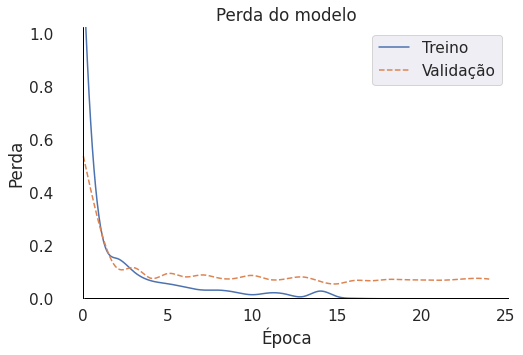

In [69]:
# (OPCIONAL) Gráfico de perda
Xloss, Yloss = createSpline(xAxis, history.history['loss'])
Xvalloss, Yvalloss = createSpline(xAxis, history.history['val_loss'])
plt.figure(figsize=(8, 5))
plt.plot(Xloss, Yloss)
plt.plot(Xvalloss, Yvalloss, '--')
formatFigure(plt)
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()

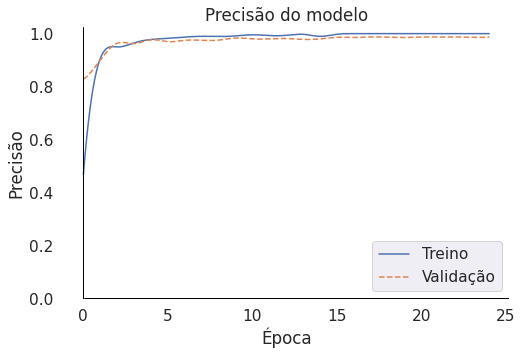

In [70]:
# (OPCIONAL) Gráfico de precisão
plt.figure(figsize=(8, 5))
Xacc, Yacc = createSpline(xAxis, history.history['accuracy'])
Xvalacc, Yvalacc = createSpline(xAxis, history.history['val_accuracy'])
plt.plot(Xacc, Yacc)
plt.plot(Xvalacc, Yvalacc, '--')
formatFigure(plt)
plt.title('Precisão do modelo')
plt.ylabel('Precisão')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='lower right')
plt.show()

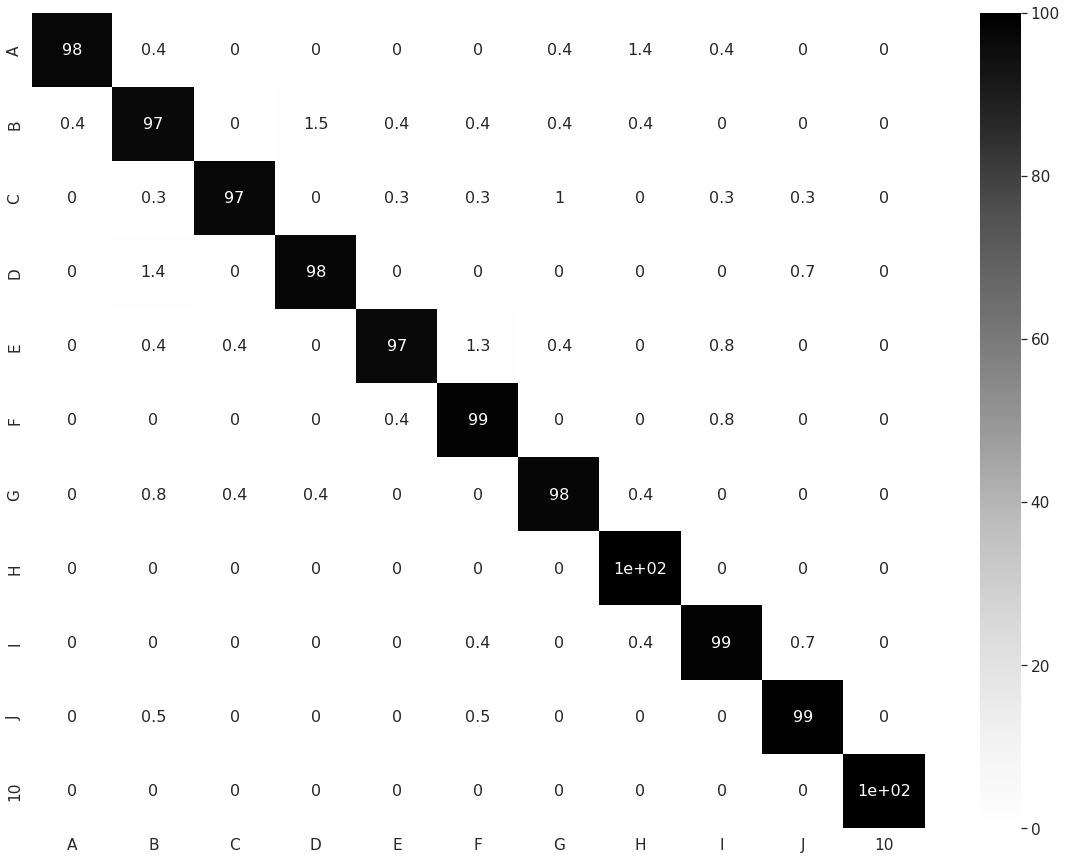

In [93]:
cm = confusion_matrix(labelsTest.argmax(axis=1), CNN.predict(dataframeTest).argmax(axis=1), normalize='true') * 100
cmRounded = [[round(num, 1) for num in line] for line in cm]
df_cm = pd.DataFrame(cmRounded, letters, letters)
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Greys')

In [ ]:
# (OPCIONAL) Carregar modelo
CNN = load_model(pathToModel)

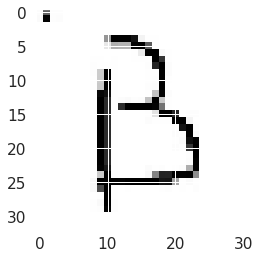

B 100.0%
[5.0270206e-18 1.0000000e+02 2.1093014e-36 3.8953849e-32 5.1733547e-26
 0.0000000e+00]


In [72]:
# (OPCIONAL) Carregar imagem e realizar predição
pathToImg = '/content/drive/MyDrive/2021.2/TCC/Testes/Data/Letras/B.jpg'
baseImg = cv2.imread(pathToImg, cv2.IMREAD_COLOR)
maxColorBaseImg = max(baseImg.flatten())
baseImgNormalized = baseImg / maxColorBaseImg
resizedBaseImage = cv2.resize(baseImgNormalized, (shapeImg[0], shapeImg[1]))

testImage = np.array(resizedBaseImage).reshape(-1, shapeImg[0], shapeImg[1], quantidadeDeCanais)
plt.imshow(resizedBaseImage)
plt.show()
y_predicted = CNN.predict(testImage)
predictScores = y_predicted[0] * 100
winnerIdx = np.argmax(predictScores)
print(numbersToLetters[winnerIdx], '{}%'.format(predictScores[winnerIdx]))
print(predictScores)